# 1. Bank Customer Churn Prediction. Introduction


[Kaggle link](https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers)

The aim of the research is:
1. to identify and visualize which factors contribute to customer churn.
2. build a prediction model that will classify if a customer is going to churn or not.

Data description.

Each customer is described by 10 features:

1.   RowNumber
2.   CustomerId
3.   Surname
4.   CreditScore
5.   Geography
6.   Gender
7.   Age
8.   Tenure
9.   Balance
10.  NumOfProducts

The target feature is "Exited" which is equal to 1 for customers who churned and 0 for others.





# 2. Importing of the libraries & settings

In [1]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import init_notebook_mode
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import IPython
import cufflinks as cf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


#from sklearn.model_selection import cross_val_score
#from sklearn import metrics
#from sklearn.pipeline import Pipeline
#from sklearn.preprocessing import OneHotEncoder, LabelEncoder
#import plotly.express as px
#from plotly import __version__
#from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [2]:
warnings.filterwarnings("ignore")

In [3]:
cf.go_offline()

In [4]:
#def enable_plotly_in_cell():
#  display(IPython.core.display.HTML('''<script src="/static/components/requirejs/require.js"></script>'''))
#  init_notebook_mode(connected=False)

# 3. Analysis and visualisation

In this section we will seek to explore the structure of our data. We'll try to understand what features probably contribute the customer churn.

In [5]:
data = pd.read_csv("Churn_Modelling.csv")
data.head()

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


We can see that
*   there are 10000 customers;
*   there are not missing values;
*   the columns have different data types: int64, float64, object.

Let's explore each feature and target variable more precise.

## 1. Target - Exited

In [7]:
data["Exited"].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [8]:
Exites_perc = data[data["Exited"] == 1].shape[0] / data.shape[0] * 100

In [9]:
#enable_plotly_in_cell()
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "xy"},{"type": "xy"}]], subplot_titles=("Churn", "% Churn"))

fig.add_trace(
    go.Bar(x = ["not Exited", "Exited"], y = list(data.groupby("Exited")["Exited"].count().values), legendgroup="1", name = "Churn"), row=1, col=1)


fig.add_trace(
    go.Bar(x = ["not Exited", "Exited"], y = [100 -  Exites_perc, Exites_perc], legendgroup="2", name = "% Churn"),
    row=1, col=2
)


fig.update_layout(height=700, width=1000)
fig.show()

In [10]:
#import os

#if not os.path.exists("images"):
#    os.mkdir("images")

In [11]:
#fig.write_image("images/fig1.jpeg")

We see that the majority of the clients stay with bank. The churn persentage is about 20%.

## 2. CustomerId

In [12]:
data["CustomerId"].nunique()

10000

All customer's Ids are unique.

## 3. Surname

In [13]:
data["Surname"].nunique()

2932

In [14]:
data["Surname"].value_counts()

Smith        32
Scott        29
Martin       29
Walker       28
Brown        26
             ..
Hendley       1
Linton        1
Light         1
Gearheart     1
Simon         1
Name: Surname, Length: 2932, dtype: int64

There are only 2932 unique surnames. But as we see that all user's ids are unique we are talking about namesakes.

## 4. Credit Score

In [15]:
data["CreditScore"].describe()

count    10000.000000
mean       650.528800
std         96.653299
min        350.000000
25%        584.000000
50%        652.000000
75%        718.000000
max        850.000000
Name: CreditScore, dtype: float64

We can see that the minimum credit score is 350, the maximum credit score is 850, the average - 650.

Let's divide people into groups in according to their CreditScore. And see the churn in each group. As the groups are not balanced, i.e. they have very different number of customers, we'll also consider the percentage of the churn in each group.

In [16]:
data["CreditScore_Range"] = pd.cut(data["CreditScore"], [349, 450, 550, 650, 750, 850])

CR1 = data["CreditScore_Range"].value_counts(sort=False)
CR2 = data[data["Exited"] == 1]["CreditScore_Range"].value_counts(sort=False)

Credit_perc_df = pd.DataFrame(
    { "Exited":round(CR2/CR1 * 100, 1).to_dict(),
     "not Exited":(100 - round(CR2/CR1 * 100, 1)).to_dict()})

Credit_perc_df.reset_index(inplace=True)
Credit_perc_df.columns = ['CreditScore', 'Exited', 'notExited']

E_CR = data.groupby("Exited")["CreditScore_Range"].value_counts(sort=False)
E_CR

Exited  CreditScore_Range
0       (349, 450]            128
        (450, 550]           1125
        (550, 650]           2627
        (650, 750]           2798
        (750, 850]           1285
1       (349, 450]             61
        (450, 550]            307
        (550, 650]            689
        (650, 750]            667
        (750, 850]            313
Name: CreditScore_Range, dtype: int64

In [17]:
#enable_plotly_in_cell()
fig = make_subplots(rows=2, cols=2, specs=[[{"type": "xy"},{"type": "xy"}], [{"type": "xy"}, {"type": "xy"}]], subplot_titles=("CreditScore & Churn", "CreditScore distribution", "Churn for CreditScore", "% of churn for CreditScore"))

fig.add_trace(go.Box(x=data["Exited"], y=data["CreditScore"], legendgroup="1", name = "CreditScore"), row=1, col=1)

fig.add_trace(go.Histogram(x=data["CreditScore"], legendgroup="2", name = "CreditScore"), row=1, col=2)

fig.add_trace(
    go.Bar(x = ["(349, 450]", "(450, 550]", "(550, 650]", "(650, 750]", "(750, 850]"], y = E_CR.values[5:], legendgroup="3", name = "Exited", marker = dict(color = 'blue')),
    row=2, col=1
)

fig.add_trace(
    go.Bar(x = ["(349, 450]", "(450, 550]", "(550, 650]", "(650, 750]", "(750, 850]"], y = E_CR.values[:5], legendgroup="3", name = "not Exited", marker = dict(color = 'orange')),
    row=2, col=1
)


fig.add_trace(
    go.Bar(x = ["(349, 450]", "(450, 550]", "(550, 650]", "(650, 750]", "(750, 850]"], y = Credit_perc_df.Exited, legendgroup="4", name = "Exited", marker = dict(color = 'blue')),
    row=2, col=2
)

fig.add_trace(
    go.Bar(x = ["(349, 450]", "(450, 550]", "(550, 650]", "(650, 750]", "(750, 850]"], y = Credit_perc_df.notExited, legendgroup="4", name = "not Exited", marker = dict(color = 'orange')),
    row=2, col=2
)

fig.update_layout(height=700, width=1000)
fig.show()

We can see the the median values in each group (Exited and not) are approximately the same.

Most often people have an average credit score. Also A big number of people has extremely big CreditScore.

The highest churn is observed for customers with a credit score in the range (349, 450], i.e. with the smallest credit score. It reaches more than 30%. But there are few people in that cathegory.

In other groups the churn procentage is approximately about 20%.

## 5. Geography

In [18]:
d = pd.DataFrame(data["Geography"].value_counts())
d.reset_index(inplace=True)
d.columns = ["Countries", "Quantity"]
d

Countries  Quantity
0    France      5014
1   Germany      2509
2     Spain      2477

Let see the value of the churn in each country. 
As number of people in the countries is not balanced we also consider the percentage of churn for each country.

In [19]:
E_G = data.groupby("Exited")["Geography"].value_counts(sort=False)
E_G

Exited  Geography
0       France       4204
        Germany      1695
        Spain        2064
1       France        810
        Germany       814
        Spain         413
Name: Geography, dtype: int64

In [20]:
Exited_France = round((data[data["Geography"] == "France"]["Exited"] == 1).value_counts()[1] / len(data[data["Geography"] == "France"]) * 100, 2)
Exited_Germany = round((data[data["Geography"] == "Germany"]["Exited"] == 1).value_counts()[1] / len(data[data["Geography"] == "Germany"])* 100, 2)
Exited_Spain = round((data[data["Geography"] == "Spain"]["Exited"] == 1).value_counts()[1] / len(data[data["Geography"] == "Spain"])* 100, 2)

In [21]:
Geography_perc_df = pd.DataFrame(
    { "Exited":{"France": Exited_France,"Germany": Exited_Germany, "Spain": Exited_Spain},  
     "not Exited":{"France": 100-Exited_France,"Germany": 100-Exited_Germany, "Spain": 100-Exited_Spain}})

In [22]:
Geography_perc_df.reset_index(inplace=True)
Geography_perc_df.columns = ['Country', 'Exited', 'notExited']

In [23]:
#enable_plotly_in_cell()
fig = make_subplots(rows=1, cols=3, specs=[[{"type": "domain"}, {"type": "xy"}, {"type": "xy"}]], subplot_titles=('Countries distribution', "Churn for Geography", "% of churn for Geography"))

fig.add_trace(go.Pie(values=list(d["Quantity"].values), labels=list(d["Countries"].values), legendgroup="1"), row=1, col=1)

fig.add_trace(
    go.Bar(x = ["France", "Germany", "Spain"], y = E_G.values[3:], legendgroup="2", name = "Exited", marker = dict(color = 'blue')),
    row=1, col=2
)

fig.add_trace(
    go.Bar(x = ["France", "Germany", "Spain"], y = E_G.values[:3], legendgroup="2", name = "not Exited", marker = dict(color = 'orange')),
    row=1, col=2
)

fig.add_trace(
    go.Bar(x = Geography_perc_df.Country, y = Geography_perc_df.Exited, legendgroup="3", name = "Exited", marker = dict(color = 'blue')),
    row=1, col=3
)

fig.add_trace(
    go.Bar(x = Geography_perc_df.Country, y = Geography_perc_df.notExited, legendgroup="3", name = "not Exited", marker = dict(color = 'orange')),
    row=1, col=3
)

fig.update_layout(height=500, width=1100)
fig.show()

We can see that the half of all clients are from France: more then 50%.

The number of client from Germany and Spain are approximately the same - about 25%.

The highest churn is observed in Germany: more than 30% of customers leave.

## 6. Gender

In [24]:
data["Gender"].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

In [25]:
E_EG = data.groupby("Exited")["Gender"].value_counts(sort=False)
E_EG

Exited  Gender
0       Female    3404
        Male      4559
1       Female    1139
        Male       898
Name: Gender, dtype: int64

In [26]:
G1 = data["Gender"].value_counts(sort=False)
G2 = data[data["Exited"] == 1]["Gender"].value_counts(sort=False)

In [27]:
Gender_perc_df = pd.DataFrame(
    { "Exited":round(G2/G1 * 100, 1).to_dict(),
     "not Exited":(100 - round(G2/G1 * 100, 1)).to_dict()})

In [28]:
Gender_perc_df.reset_index(inplace=True)
Gender_perc_df.columns = ['Gender', 'Exited', 'notExited']

In [29]:
#enable_plotly_in_cell()
fig = make_subplots(rows=1, cols=3, specs=[[{"type": "xy"}, {"type": "xy"}, {"type": "xy"}]], subplot_titles=('Gender & Churn', "Churn for Gender", "% of churn for Gender"))

fig.add_trace(go.Bar(x = ["Male", "Female"], y = list(data["Gender"].value_counts().values), legendgroup="1", name = "Gender"), row=1, col=1)

fig.add_trace(
    go.Bar(x = ["Male", "Female"], y = E_EG.values[2:][::-1], legendgroup="2", name = "Exited", marker = dict(color = 'blue')),
    row=1, col=2
)

fig.add_trace(
    go.Bar(x = ["Male", "Female"], y = E_EG.values[:2][::-1], legendgroup="2", name = "not Exited", marker = dict(color = 'orange')),
    row=1, col=2
)

fig.add_trace(
    go.Bar(x = Gender_perc_df.Gender, y = Gender_perc_df.Exited, legendgroup="3", name = "Exited", marker = dict(color = 'blue')),
    row=1, col=3
)

fig.add_trace(
    go.Bar(x = Gender_perc_df.Gender, y = Gender_perc_df.notExited, legendgroup="3", name = "not Exited", marker = dict(color = 'orange')),
    row=1, col=3
)

fig.update_layout(height=500, width=1100)
fig.show()

The total number of men is greater than total number of women

But the churn for the women is greater. It's about 25% in comparison with 16% for men.

## 7. Age

In [30]:
data["Age"].describe()

count    10000.000000
mean        38.921800
std         10.487806
min         18.000000
25%         32.000000
50%         37.000000
75%         44.000000
max         92.000000
Name: Age, dtype: float64

The youngest person is 18 years old. And the oldest person is 92 years old. The mean age is about 39 years.

Let's divide all customers into the groups in according with their age and analyse the data.

In [31]:
data["Age_Range"] = pd.cut(data["Age"], [17, 30, 40, 50, 60, 70, 80, 93])

In [32]:
A1 = data["Age_Range"].value_counts(sort=False)
A2 = data[data["Exited"] == 1]["Age_Range"].value_counts(sort=False)

In [33]:
Age_perc_df = pd.DataFrame(
    { "Exited": round(A2/A1 * 100, 2).to_dict(),
     "notExited":(100 - round(A2/A1 * 100, 2)).to_dict()})

In [34]:
Age_perc_df.reset_index(inplace=True)
Age_perc_df.columns = ['Age', 'Exited', 'notExited']

In [35]:
E_AR = data.groupby("Exited")["Age_Range"].value_counts(sort=False)
E_AR

Exited  Age_Range
0       (17, 30]     1820
        (30, 40]     3913
        (40, 50]     1532
        (50, 60]      349
        (60, 70]      227
        (70, 80]      111
        (80, 93]       11
1       (17, 30]      148
        (30, 40]      538
        (40, 50]      788
        (50, 60]      448
        (60, 70]      104
        (70, 80]       10
        (80, 93]        1
Name: Age_Range, dtype: int64

In [36]:
#enable_plotly_in_cell()
fig = make_subplots(rows=2, cols=2, specs=[[{"type": "xy"},{"type": "xy"}], [{"type": "xy"}, {"type": "xy"}]], subplot_titles=("Age & Churn", "Age distribution", "Churn for Age", "% of churn for Age"))

fig.add_trace(go.Box(x=data["Exited"], y=data["Age"], legendgroup="1", name = "Age"), row=1, col=1)

fig.add_trace(go.Histogram(x=data["Age"], legendgroup="2", name = "Age"), row=1, col=2)

fig.add_trace(
    go.Bar(x = ["(17, 30]", "(30, 40]", "(40, 50]", "(50, 60]", "(60, 70]", "(70, 80]", "(80, 93]"], y = E_AR.values[7:], legendgroup="3", name = "Exited", marker = dict(color = 'blue')),
    row=2, col=1
)

fig.add_trace(
    go.Bar(x = ["(17, 30]", "(30, 40]", "(40, 50]", "(50, 60]", "(60, 70]", "(70, 80]", "(80, 93]"], y = E_AR.values[:7], legendgroup="3", name = "not Exited", marker = dict(color = 'orange')),
    row=2, col=1
)


fig.add_trace(
    go.Bar(x = ["(17, 30]", "(30, 40]", "(40, 50]", "(50, 60]", "(60, 70]", "(70, 80]", "(80, 93]"], y = Age_perc_df.Exited, legendgroup="4", name = "Exited", marker = dict(color = 'blue')),
    row=2, col=2
)

fig.add_trace(
    go.Bar(x = ["(17, 30]", "(30, 40]", "(40, 50]", "(50, 60]", "(60, 70]", "(70, 80]", "(80, 93]"], y = Age_perc_df.notExited, legendgroup="4", name = "not Exited", marker = dict(color = 'orange')),
    row=2, col=2
)

fig.update_layout(height=700, width=1000)
fig.show()

Most people are in the age range from 30 to 45 years.

We can see that the median age in the "Exited" group is much more greater: 45 years in comparison with 36 years.

Thus, there is the correlation between the age and the churn. More older people leave more often.

The churn rate reaches it's summit for the range (50, 60]. For this group the percentage of the churn reaches 56%.

## 8. Tenure

In [37]:
data["Tenure"].value_counts()

2     1048
1     1035
7     1028
8     1025
5     1012
3     1009
4      989
9      984
6      967
10     490
0      413
Name: Tenure, dtype: int64

There are 11 different values for "Tenure" feature. Let's explore the dependence between this feature and the churn.

In [38]:
data.groupby("Exited")["Tenure"].value_counts(sort=False)

Exited  Tenure
0       0         318
        1         803
        2         847
        3         796
        4         786
        5         803
        6         771
        7         851
        8         828
        9         771
        10        389
1       0          95
        1         232
        2         201
        3         213
        4         203
        5         209
        6         196
        7         177
        8         197
        9         213
        10        101
Name: Tenure, dtype: int64

In [39]:
t = pd.DataFrame(data["Tenure"].value_counts())
t.reset_index(inplace=True)
t.columns = ["Tenure", "Quantity"]

In [40]:
T1 = data["Tenure"].value_counts(sort=False)
T2 = data[data["Exited"] == 1]["Tenure"].value_counts(sort=False)

In [41]:
Tenure_perc_df = pd.DataFrame(
    { "Exited": round(T2/T1 * 100, 2).to_dict(),
     "notExited":(100 - round(T2/T1 * 100, 2)).to_dict()})

In [42]:
Tenure_perc_df.reset_index(inplace=True)
Tenure_perc_df.columns = ['Tenure', 'Exited', 'notExited']

In [43]:
#enable_plotly_in_cell()
fig = make_subplots(rows=2, cols=2, specs=[[{"type": "domain"},{"type": "xy"}], [{"type": "xy"}, {"type": "xy"}]], subplot_titles=("Tenure", "Tenure distribution", "Churn for Tenure", "% of churn for Tenure"))

fig.add_trace(go.Pie(values=list(t["Quantity"].values), labels=list(t["Tenure"].values), legendgroup="1"), row=1, col=1)


fig.add_trace(go.Bar(x = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10"], y = list(data.groupby("Tenure")["Tenure"].count().values), legendgroup="2", name = "Tenure"), row=1, col=2)


fig.add_trace(
    go.Bar(x = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10"], y = list(data.groupby("Exited")["Tenure"].value_counts(sort=False).values)[11:], legendgroup="3", name = "Exited", marker = dict(color = 'blue')),
    row=2, col=1
)

fig.add_trace(
    go.Bar(x = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10"], y = list(data.groupby("Exited")["Tenure"].value_counts(sort=False).values)[:11], legendgroup="3", name = "not Exited", marker = dict(color = 'orange')),
    row=2, col=1
)


fig.add_trace(
    go.Bar(x = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10"], y = Tenure_perc_df.Exited, legendgroup="4", name = "Exited", marker = dict(color = 'blue')),
    row=2, col=2
)

fig.add_trace(
    go.Bar(x = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10"], y = Tenure_perc_df.notExited, legendgroup="4", name = "not Exited", marker = dict(color = 'orange')),
    row=2, col=2
)

fig.update_layout(height=700, width=1000)
fig.show()

We can see that all groups of "Tenure" feature are preaented enought.

The smallest number of representatives is contained in groups 0 and 10.

The percentage of the churn in each category of the tenure is approximately the same.

## 9. Balance

In [44]:
data["Balance"].describe()

count     10000.000000
mean      76485.889288
std       62397.405202
min           0.000000
25%           0.000000
50%       97198.540000
75%      127644.240000
max      250898.090000
Name: Balance, dtype: float64

The minimum value of a balance is equal to 0. The maximum value of a balance is equal to 250898. And the average is 76485.

Let's explore more deeply.

In [45]:
data["Balance_Range"] = pd.cut(data["Balance"], [-0.1, 25290, 50580, 75870, 101160, 126450, 151740, 177030, 202320, 227610, 252900])

In [46]:
B1 = data["Balance_Range"].value_counts(sort=False)
B2 = data[data["Exited"] == 1]["Balance_Range"].value_counts(sort=False)

In [47]:
Balance_perc_df = pd.DataFrame(
    { "Exited":round(B2/B1 * 100, 1).to_dict(),
     "notExited":(100 - round(B2/B1 * 100, 1)).to_dict()})

In [48]:
Balance_perc_df.reset_index(inplace=True)
Balance_perc_df.columns = ['Balance', 'Exited', 'notExited']

In [49]:
E_B = data.groupby("Exited")["Balance_Range"].value_counts(sort=False)
E_B

Exited  Balance_Range       
0       (-0.1, 25290.0]         3119
        (25290.0, 50580.0]        48
        (50580.0, 75870.0]       289
        (75870.0, 101160.0]      981
        (101160.0, 126450.0]    1539
        (126450.0, 151740.0]    1301
        (151740.0, 177030.0]     547
        (177030.0, 202320.0]     126
        (202320.0, 227610.0]      13
1       (-0.1, 25290.0]          504
        (25290.0, 50580.0]        22
        (50580.0, 75870.0]        82
        (75870.0, 101160.0]      235
        (101160.0, 126450.0]     572
        (126450.0, 151740.0]     411
        (151740.0, 177030.0]     151
        (177030.0, 202320.0]      44
        (202320.0, 227610.0]      14
        (227610.0, 252900.0]       2
Name: Balance_Range, dtype: int64

In [50]:
#enable_plotly_in_cell()
fig = make_subplots(rows=2, cols=2, specs=[[{"type": "xy"},{"type": "xy"}], [{"type": "xy"}, {"type": "xy"}]], subplot_titles=("Balance & Churn", "Balance distribution", "Churn for Balance", "% of churn for Balance"))

fig.add_trace(go.Box(x=data["Exited"], y=data["Balance"], legendgroup="1", name = "Balance"), row=1, col=1)

fig.add_trace(go.Histogram(x=data["Balance"], legendgroup="2", name = "Age"), row=1, col=2)

fig.add_trace(
    go.Bar(x = ["(-0.1, 25290]", "(25290, 50580]", "(50580, 75870]", "(75870, 101160]", "(101160, 126450]", "(126450, 151740]", "(151740, 177030]", "(177030, 202320]", "(202320, 227610]", "(227610, 252900]"], y = E_B.values[9:], legendgroup="3", name = "Exited", marker = dict(color = 'blue')),
    row=2, col=1
)

fig.add_trace(
    go.Bar(x = ["(-0.1, 25290]", "(25290, 50580]", "(50580, 75870]", "(75870, 101160]", "(101160, 126450]", "(126450, 151740]", "(151740, 177030]", "(177030, 202320]", "(202320, 227610]", "(227610, 252900]"], y = np.append(E_B.values[:9], 0), legendgroup="3", name = "not Exited", marker = dict(color = 'orange')),
    row=2, col=1
)


fig.add_trace(
    go.Bar(x = ["(-0.1, 25290]", "(25290, 50580]", "(50580, 75870]", "(75870, 101160]", "(101160, 126450]", "(126450, 151740]", "(151740, 177030]", "(177030, 202320]", "(202320, 227610]", "(227610, 252900]"], y = Balance_perc_df.Exited, legendgroup="4", name = "Exited", marker = dict(color = 'blue')),
    row=2, col=2
)

fig.add_trace(
    go.Bar(x = ["(-0.1, 25290]", "(25290, 50580]", "(50580, 75870]", "(75870, 101160]", "(101160, 126450]", "(126450, 151740]", "(151740, 177030]", "(177030, 202320]", "(202320, 227610]", "(227610, 252900]"], y = Balance_perc_df.notExited, legendgroup="4", name = "not Exited", marker = dict(color = 'orange')),
    row=2, col=2
)

fig.update_layout(height=700, width=1000)
fig.show()

In [51]:
data[data["Balance"] >= 202320].shape[0]

29

We can see from the distribution that there are a lot of people with zero-balance. 
 
We have seen that the average value of the Balance is 76000. But, if we exclude customers with zero-balances, the majority has a balance in the range from 100000 to 150000.

People in "Exited" group have greater median balance that in "not Exited" group: 109000 in comparison with 92000.

The people with the highest balance (> 200000) are tended to leave. But there are few such people: only 29 persons have the balance more than 202320.

Thus, we can suppose that there is a correlation between the churn and the balance.

## 10. NumOfProducts

In [52]:
data["NumOfProducts"].value_counts()

1    5084
2    4590
3     266
4      60
Name: NumOfProducts, dtype: int64

There are only 4 possible number of products. Let's explore further.


In [53]:
d = pd.DataFrame(data["NumOfProducts"].value_counts())
d.reset_index(inplace=True)
d.columns = ["NumOfProducts", "Quantity"]
d

NumOfProducts  Quantity
0              1      5084
1              2      4590
2              3       266
3              4        60

In [54]:
E_E = data.groupby("Exited")["NumOfProducts"].value_counts(sort=False)
E_E

Exited  NumOfProducts
0       1                3675
        2                4242
        3                  46
1       1                1409
        2                 348
        3                 220
        4                  60
Name: NumOfProducts, dtype: int64

In [55]:
n = pd.DataFrame(data["NumOfProducts"].value_counts())
n.reset_index(inplace=True)
n.columns = ["NumOfProducts", "Quantity"]
N1 = data["NumOfProducts"].value_counts(sort=False)
N2 = data[data["Exited"] == 1]["NumOfProducts"].value_counts(sort=False)
NumOfProducts_perc_df = pd.DataFrame(
    { "Exited": round(N2/N1 * 100, 2).to_dict(),
     "notExited":(100 - round(N2/N1 * 100, 2)).to_dict()})
NumOfProducts_perc_df.reset_index(inplace=True)
NumOfProducts_perc_df.columns = ['NumOfProducts', 'Exited', 'notExited']

In [56]:
#enable_plotly_in_cell()
fig = make_subplots(rows=2, cols=2, specs=[[{"type": "domain"},{"type": "xy"}], [{"type": "xy"}, {"type": "xy"}]], subplot_titles=("NumOfProducts", "NumOfProducts distribution", "Churn for NumOfProducts", "% of churn for NumOfProducts"))

fig.add_trace(go.Pie(values=list(d["Quantity"].values), labels=list(d["NumOfProducts"].values), legendgroup="1"), row=1, col=1)


fig.add_trace(go.Bar(x = ["1", "2", "3", "4"], y = list(data.groupby("NumOfProducts")["NumOfProducts"].count().values), legendgroup="2", name = "NumOfProducts"), row=1, col=2)


fig.add_trace(
    go.Bar(x = ["1", "2", "3", "4"], y = E_E.values[3:], legendgroup="3", name = "Exited", marker = dict(color = 'blue')),
    row=2, col=1
)

fig.add_trace(
    go.Bar(x = ["1", "2", "3", "4"], y = np.append(E_E.values[:3], 0), legendgroup="3", name = "not Exited", marker = dict(color = 'orange')),
    row=2, col=1
)


fig.add_trace(
    go.Bar(x = ["1", "2", "3", "4"], y = NumOfProducts_perc_df.Exited, legendgroup="4", name = "Exited", marker = dict(color = 'blue')),
    row=2, col=2
)

fig.add_trace(
    go.Bar(x = ["1", "2", "3", "4"], y = NumOfProducts_perc_df.notExited, legendgroup="4", name = "not Exited", marker = dict(color = 'orange')),
    row=2, col=2
)

fig.update_layout(height=500, width=1000)
fig.show()

We see that most often people have 1 or 2 products.  Other options account for only 2.66% for 3 products and 0.6% for 4 products.

The smallest churn is observed for customers with 2 products. They might be regular customers.

For customers with 3 products the churn is about 82%.

All customers (only 4 persons) with 4 products leave.

## 11. HasCrCard

In [57]:
data["HasCrCard"].value_counts()

1    7055
0    2945
Name: HasCrCard, dtype: int64

The majority of customers has credit cards.

In [58]:
E_H = data.groupby("Exited")["HasCrCard"].value_counts(sort=False)
E_H

Exited  HasCrCard
0       0            2332
        1            5631
1       0             613
        1            1424
Name: HasCrCard, dtype: int64

In [59]:
H1 = data["HasCrCard"].value_counts(sort=False)
H2 = data[data["Exited"] == 1]["HasCrCard"].value_counts(sort=False)

HasCrCard_perc_df = pd.DataFrame(
    { "Exited":round(H2/H1 * 100, 1).to_dict(),
     "not Exited":(100 - round(H2/H1 * 100, 1)).to_dict()})

HasCrCard_perc_df.reset_index(inplace=True)
HasCrCard_perc_df.columns = ['HasCrCard', 'Exited', 'notExited']

In [60]:
#enable_plotly_in_cell()
fig = make_subplots(rows=1, cols=3, specs=[[{"type": "xy"}, {"type": "xy"}, {"type": "xy"}]], subplot_titles=('HasCrCard & Churn', "Churn for HasCrCard", "% of churn for HasCrCard"))

fig.add_trace(go.Bar(x = ["1", "0"], y = list(data["HasCrCard"].value_counts().values), legendgroup="1", name = "HasCrCard"), row=1, col=1)

fig.add_trace(
    go.Bar(x = ["1", "0"], y = list(E_H.values[2:][::-1]), legendgroup="2", name = "Exited", marker = dict(color = 'blue')),
    row=1, col=2
)

fig.add_trace(
    go.Bar(x = ["1", "0"], y = list(E_H.values[:2][::-1]), legendgroup="2", name = "not Exited", marker = dict(color = 'orange')),
    row=1, col=2
)

fig.add_trace(
    go.Bar(x = HasCrCard_perc_df.HasCrCard, y = HasCrCard_perc_df.Exited, legendgroup="3", name = "Exited", marker = dict(color = 'blue')),
    row=1, col=3
)

fig.add_trace(
    go.Bar(x = HasCrCard_perc_df.HasCrCard, y = HasCrCard_perc_df.notExited, legendgroup="3", name = "not Exited", marker = dict(color = 'orange')),
    row=1, col=3
)

fig.update_layout(height=500, width=1000)
fig.show()

We see that the percentage of the churn is approximately the same for two groups.

## 12. IsActiveMember

In [61]:
data["IsActiveMember"].value_counts()

1    5151
0    4849
Name: IsActiveMember, dtype: int64

Here customers are divided approximately in half.

In [62]:
E_I = data.groupby("Exited")["IsActiveMember"].value_counts(sort=False)
E_I

Exited  IsActiveMember
0       0                 3547
        1                 4416
1       0                 1302
        1                  735
Name: IsActiveMember, dtype: int64

In [63]:
I1 = data["IsActiveMember"].value_counts(sort=False)
I2 = data[data["Exited"] == 1]["IsActiveMember"].value_counts(sort=False)

IsActiveMember_perc_df = pd.DataFrame(
    { "Exited":round(I2/I1 * 100, 1).to_dict(),
     "not Exited":(100 - round(I2/I1 * 100, 1)).to_dict()})

IsActiveMember_perc_df.reset_index(inplace=True)
IsActiveMember_perc_df.columns = ['IsActiveMember', 'Exited', 'notExited']

In [64]:
#enable_plotly_in_cell()
fig = make_subplots(rows=1, cols=3, specs=[[{"type": "xy"}, {"type": "xy"}, {"type": "xy"}]], subplot_titles=('IsActiveMember & Churn', "Churn for IsActiveMember", "% of churn for IsActiveMember"))

fig.add_trace(go.Bar(x = ["1", "0"], y = list(data["IsActiveMember"].value_counts().values), legendgroup="1", name = "IsActiveMember"), row=1, col=1)

fig.add_trace(
    go.Bar(x = ["1", "0"], y = list(E_I.values[2:][::-1]), legendgroup="2", name = "Exited", marker = dict(color = 'blue')),
    row=1, col=2
)

fig.add_trace(
    go.Bar(x = ["1", "0"], y = list(E_I.values[:2][::-1]), legendgroup="2", name = "not Exited", marker = dict(color = 'orange')),
    row=1, col=2
)

fig.add_trace(
    go.Bar(x = IsActiveMember_perc_df.IsActiveMember, y = IsActiveMember_perc_df.Exited, legendgroup="3", name = "Exited", marker = dict(color = 'blue')),
    row=1, col=3
)

fig.add_trace(
    go.Bar(x = IsActiveMember_perc_df.IsActiveMember, y = IsActiveMember_perc_df.notExited, legendgroup="3", name = "not Exited", marker = dict(color = 'orange')),
    row=1, col=3
)

fig.update_layout(height=500, width=1000)
fig.show()

The result is quite logical: among regular customers the churn is much less.

## 13. EstimatedSalary

In [65]:
data["EstimatedSalary"].describe()

count     10000.000000
mean     100090.239881
std       57510.492818
min          11.580000
25%       51002.110000
50%      100193.915000
75%      149388.247500
max      199992.480000
Name: EstimatedSalary, dtype: float64

We can see that the min salary is 11.58, the max salary is almost 200000 and the average salary is about 100000.

In [66]:
data["EstimatedSalary_Range"] = pd.cut(data["EstimatedSalary"], [11, 20000, 40000, 60000, 80000, 100000, 120000, 140000, 160000, 180000, 200000])

In [67]:
S1 = data["EstimatedSalary_Range"].value_counts(sort=False)
S2 = data[data["Exited"] == 1]["EstimatedSalary_Range"].value_counts(sort=False)

In [68]:
EstimatedSalary_perc_df = pd.DataFrame(
    { "Exited":round(S2/S1 * 100, 1).to_dict(),
     "notExited":(100 - round(S2/S1 * 100, 1)).to_dict()})

In [69]:
EstimatedSalary_perc_df.reset_index(inplace=True)
EstimatedSalary_perc_df.columns = ['EstimatedSalary', 'Exited', 'notExited']

In [70]:
E_S = data.groupby("Exited")["EstimatedSalary_Range"].value_counts(sort=False)
E_S

Exited  EstimatedSalary_Range
0       (11, 20000]              788
        (20000, 40000]           773
        (40000, 60000]           815
        (60000, 80000]           815
        (80000, 100000]          806
        (100000, 120000]         816
        (120000, 140000]         811
        (140000, 160000]         776
        (160000, 180000]         784
        (180000, 200000]         779
1       (11, 20000]              198
        (20000, 40000]           196
        (40000, 60000]           191
        (60000, 80000]           212
        (80000, 100000]          196
        (100000, 120000]         211
        (120000, 140000]         196
        (140000, 160000]         206
        (160000, 180000]         225
        (180000, 200000]         206
Name: EstimatedSalary_Range, dtype: int64

In [71]:
#enable_plotly_in_cell()
fig = make_subplots(rows=2, cols=2, specs=[[{"type": "xy"},{"type": "xy"}], [{"type": "xy"}, {"type": "xy"}]], subplot_titles=("EstimatedSalary & Churn", "EstimatedSalary distribution", "Churn for EstimatedSalary", "% of churn for EstimatedSalary"))

fig.add_trace(go.Box(x=data["Exited"], y=data["EstimatedSalary"], legendgroup="1", name = "EstimatedSalary"), row=1, col=1)

fig.add_trace(go.Histogram(x=data["EstimatedSalary"], legendgroup="2", name = "EstimatedSalary"), row=1, col=2)

fig.add_trace(
    go.Bar(x = ["(11, 20000]", "(20000, 40000]", "(40000, 60000]", "(60000, 80000]", "(80000, 100000]", "(100000, 120000]", "(120000, 140000]", "(140000, 160000]", "(160000, 180000]", "(180000, 200000]"], y = E_S.values[10:], legendgroup="3", name = "Exited", marker = dict(color = 'blue')),
    row=2, col=1
)

fig.add_trace(
    go.Bar(x = ["(11, 20000]", "(20000, 40000]", "(40000, 60000]", "(60000, 80000]", "(80000, 100000]", "(100000, 120000]", "(120000, 140000]", "(140000, 160000]", "(160000, 180000]", "(180000, 200000]"], y = E_S.values[:10], legendgroup="3", name = "not Exited", marker = dict(color = 'orange')),
    row=2, col=1
)


fig.add_trace(
    go.Bar(x = ["(11, 20000]", "(20000, 40000]", "(40000, 60000]", "(60000, 80000]", "(80000, 100000]", "(100000, 120000]", "(120000, 140000]", "(140000, 160000]", "(160000, 180000]", "(180000, 200000]"], y = EstimatedSalary_perc_df.Exited, legendgroup="4", name = "Exited", marker = dict(color = 'blue')),
    row=2, col=2
)

fig.add_trace(
    go.Bar(x = ["(11, 20000]", "(20000, 40000]", "(40000, 60000]", "(60000, 80000]", "(80000, 100000]", "(100000, 120000]", "(120000, 140000]", "(140000, 160000]", "(160000, 180000]", "(180000, 200000]"], y = EstimatedSalary_perc_df.notExited, legendgroup="4", name = "not Exited", marker = dict(color = 'orange')),
    row=2, col=2
)

fig.update_layout(height=700, width=1000)
fig.show()

The median salary in each group ("Exited" and "not Exited") is approximately the same.

The distribution of the salary is quite uniform.

The churn in each group of the salary is about the same.


Now, let's remove the columns that aren't supposed to affect the churn. Also we'll remove auxiliary columns.

In [131]:
df = data.drop(["RowNumber", "CustomerId", "Surname", "CreditScore_Range", "Age_Range", "Balance_Range", "EstimatedSalary_Range"], axis=1)
df

CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0             619    France  Female   42       2       0.00              1   
1             608     Spain  Female   41       1   83807.86              1   
2             502    France  Female   42       8  159660.80              3   
3             699    France  Female   39       1       0.00              2   
4             850     Spain  Female   43       2  125510.82              1   
...           ...       ...     ...  ...     ...        ...            ...   
9995          771    France    Male   39       5       0.00              2   
9996          516    France    Male   35      10   57369.61              1   
9997          709    France  Female   36       7       0.00              1   
9998          772   Germany    Male   42       3   75075.31              2   
9999          792    France  Female   28       4  130142.79              1   

      HasCrCard  IsActiveMember  EstimatedSalary  Exited  
0             1               1        101348.88       1  
1             0               1        112542.58       0  
2             1               0        113931.57       1  
3             0               0         93826.63       0  
4             1               1         79084.10       0  
...         ...             ...              ...     ...  
9995          1               0         96270.64       0  
9996          1               1        101699.77       0  
9997          0               1         42085.58       1  
9998          1               0         92888.52       1  
9999          1               0         38190.78       0  

[10000 rows x 11 columns]

In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


Let's define the names of the numerical and categorical columns.

In [133]:
s = (df.dtypes == 'object')
cath_cols = list(s[s].index)
print("Categorical variables:")
print(cath_cols)

Categorical variables:
['Geography', 'Gender']


In [134]:
s = (df.dtypes != 'object')
num_cols = list(s[s].index)
print("Numerical variables:")
print(num_cols)

Numerical variables:
['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']


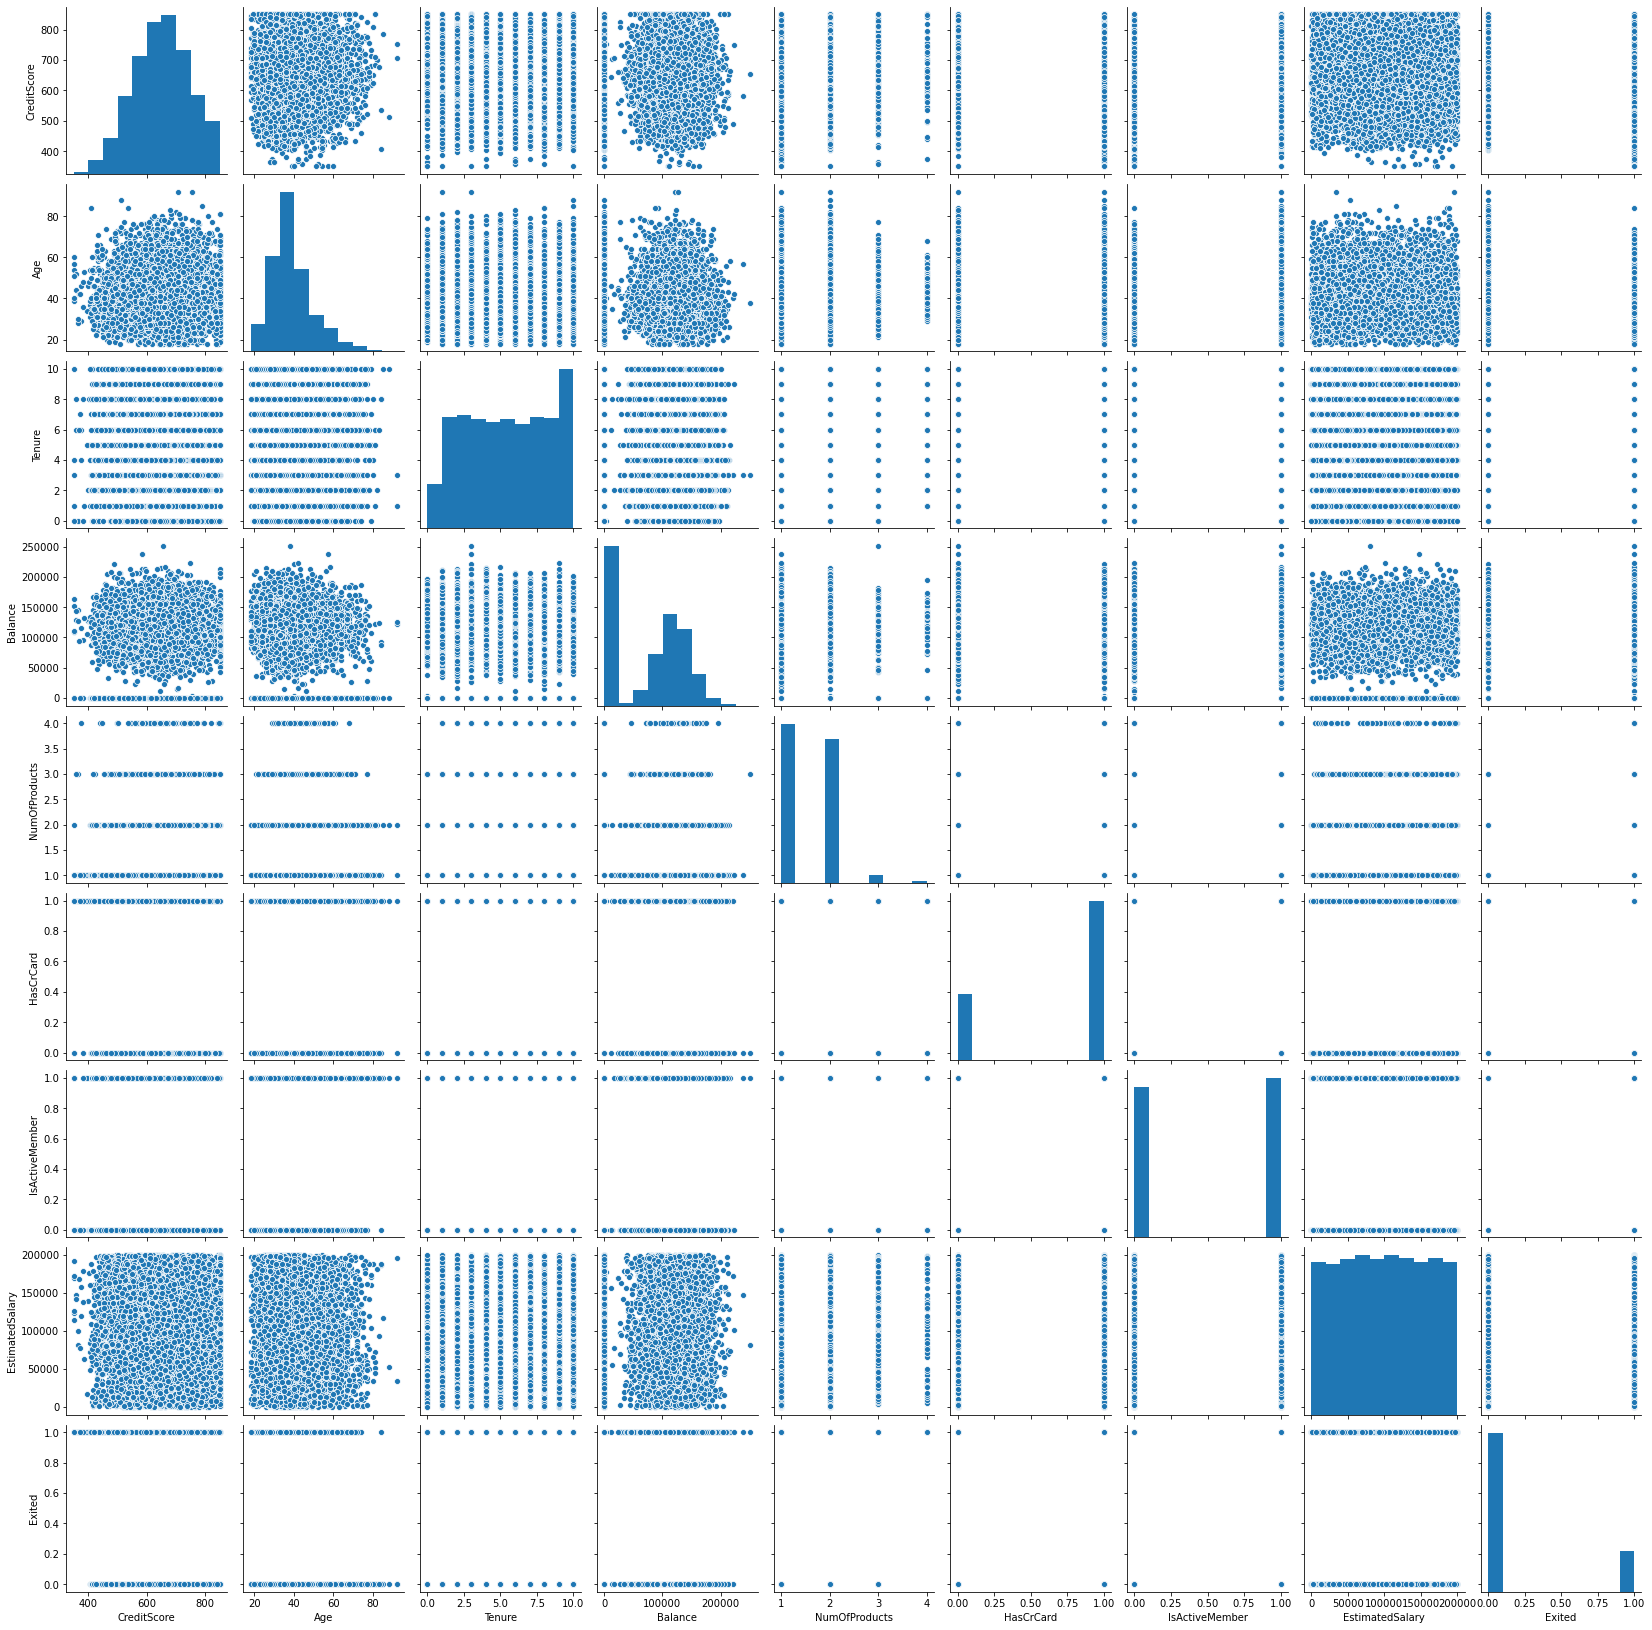

In [142]:
sns.pairplot(df[num_cols])

Construct the correlation matrix.

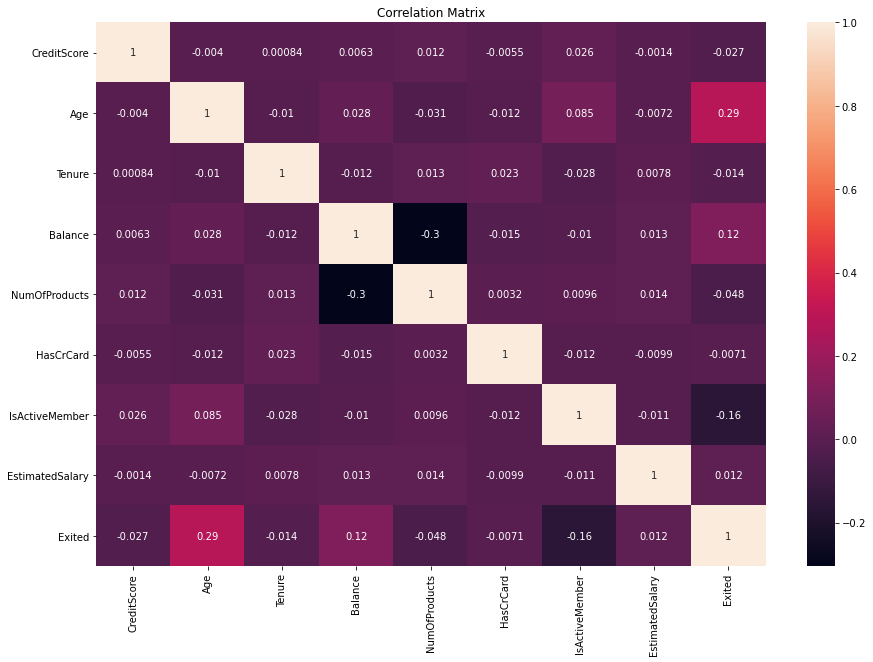

In [138]:
corr_matrix = df[num_cols].corr()

f, ax = plt.subplots(figsize= [15,10])
sns.heatmap(corr_matrix, annot=True)
ax.set_title("Correlation Matrix")
f.show()

Here we can see that the feature "Age" has the highest positive correlation with the churn, The next is "Balance". The highest negative correlation is concidered for "IsActiveMember" feuture and the churn. This all looks reasonable.

# 4. Data Preprocessing

Let's preprocess data for machine learning models.

Let's extract the target value and remove it from the dataset.

In [78]:
y = data["Exited"].values
df.drop(["Exited"], axis=1, inplace=True)
print("y = ", y, "\n\n")
df

y =  [1 0 1 ... 1 1 0] 




CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0             619    France  Female   42       2       0.00              1   
1             608     Spain  Female   41       1   83807.86              1   
2             502    France  Female   42       8  159660.80              3   
3             699    France  Female   39       1       0.00              2   
4             850     Spain  Female   43       2  125510.82              1   
...           ...       ...     ...  ...     ...        ...            ...   
9995          771    France    Male   39       5       0.00              2   
9996          516    France    Male   35      10   57369.61              1   
9997          709    France  Female   36       7       0.00              1   
9998          772   Germany    Male   42       3   75075.31              2   
9999          792    France  Female   28       4  130142.79              1   

      HasCrCard  IsActiveMember  EstimatedSalary  
0             1               1        101348.88  
1             0               1        112542.58  
2             1               0        113931.57  
3             0               0         93826.63  
4             1               1         79084.10  
...         ...             ...              ...  
9995          1               0         96270.64  
9996          1               1        101699.77  
9997          0               1         42085.58  
9998          1               0         92888.52  
9999          1               0         38190.78  

[10000 rows x 10 columns]

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
dtypes: float64(2), int64(6), object(2)
memory usage: 781.4+ KB


We have only 2 object-columns: "Gender" and "Geography". Both of them are categorical.

Let's create the dummy variables for these features.

In [80]:
dummy_gend = pd.get_dummies(df["Gender"])
dummy_gend

Female  Male
0          1     0
1          1     0
2          1     0
3          1     0
4          1     0
...      ...   ...
9995       0     1
9996       0     1
9997       1     0
9998       0     1
9999       1     0

[10000 rows x 2 columns]

In [81]:
dummy_geo = pd.get_dummies(df["Geography"])
dummy_geo

France  Germany  Spain
0          1        0      0
1          0        0      1
2          1        0      0
3          1        0      0
4          0        0      1
...      ...      ...    ...
9995       1        0      0
9996       1        0      0
9997       1        0      0
9998       0        1      0
9999       1        0      0

[10000 rows x 3 columns]

Let's add the dummy columns to the dataset.

In [82]:
df = pd.concat([df, dummy_gend, dummy_geo], axis=1)
df

CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0             619    France  Female   42       2       0.00              1   
1             608     Spain  Female   41       1   83807.86              1   
2             502    France  Female   42       8  159660.80              3   
3             699    France  Female   39       1       0.00              2   
4             850     Spain  Female   43       2  125510.82              1   
...           ...       ...     ...  ...     ...        ...            ...   
9995          771    France    Male   39       5       0.00              2   
9996          516    France    Male   35      10   57369.61              1   
9997          709    France  Female   36       7       0.00              1   
9998          772   Germany    Male   42       3   75075.31              2   
9999          792    France  Female   28       4  130142.79              1   

      HasCrCard  IsActiveMember  EstimatedSalary  Female  Male  France  \
0             1               1        101348.88       1     0       1   
1             0               1        112542.58       1     0       0   
2             1               0        113931.57       1     0       1   
3             0               0         93826.63       1     0       1   
4             1               1         79084.10       1     0       0   
...         ...             ...              ...     ...   ...     ...   
9995          1               0         96270.64       0     1       1   
9996          1               1        101699.77       0     1       1   
9997          0               1         42085.58       1     0       1   
9998          1               0         92888.52       0     1       0   
9999          1               0         38190.78       1     0       1   

      Germany  Spain  
0           0      0  
1           0      1  
2           0      0  
3           0      0  
4           0      1  
...       ...    ...  
9995        0      0  
9996        0      0  
9997        0      0  
9998        1      0  
9999        0      0  

[10000 rows x 15 columns]

The "NumOfProducts" feature is also categorical, but with int values. Let's encode it as well.

In [83]:
dummy_np = pd.get_dummies(df["NumOfProducts"])
dummy_np

1  2  3  4
0     1  0  0  0
1     1  0  0  0
2     0  0  1  0
3     0  1  0  0
4     1  0  0  0
...  .. .. .. ..
9995  0  1  0  0
9996  1  0  0  0
9997  1  0  0  0
9998  0  1  0  0
9999  1  0  0  0

[10000 rows x 4 columns]

Adding the dummy column for "NumOfProducts".


In [84]:
df = pd.concat([df, dummy_np], axis=1)
df

CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0             619    France  Female   42       2       0.00              1   
1             608     Spain  Female   41       1   83807.86              1   
2             502    France  Female   42       8  159660.80              3   
3             699    France  Female   39       1       0.00              2   
4             850     Spain  Female   43       2  125510.82              1   
...           ...       ...     ...  ...     ...        ...            ...   
9995          771    France    Male   39       5       0.00              2   
9996          516    France    Male   35      10   57369.61              1   
9997          709    France  Female   36       7       0.00              1   
9998          772   Germany    Male   42       3   75075.31              2   
9999          792    France  Female   28       4  130142.79              1   

      HasCrCard  IsActiveMember  EstimatedSalary  Female  Male  France  \
0             1               1        101348.88       1     0       1   
1             0               1        112542.58       1     0       0   
2             1               0        113931.57       1     0       1   
3             0               0         93826.63       1     0       1   
4             1               1         79084.10       1     0       0   
...         ...             ...              ...     ...   ...     ...   
9995          1               0         96270.64       0     1       1   
9996          1               1        101699.77       0     1       1   
9997          0               1         42085.58       1     0       1   
9998          1               0         92888.52       0     1       0   
9999          1               0         38190.78       1     0       1   

      Germany  Spain  1  2  3  4  
0           0      0  1  0  0  0  
1           0      1  1  0  0  0  
2           0      0  0  0  1  0  
3           0      0  0  1  0  0  
4           0      1  1  0  0  0  
...       ...    ... .. .. .. ..  
9995        0      0  0  1  0  0  
9996        0      0  1  0  0  0  
9997        0      0  1  0  0  0  
9998        1      0  0  1  0  0  
9999        0      0  1  0  0  0  

[10000 rows x 19 columns]

Let's drop the original columns "Gender", "Geography", "NumOfProducts", also the features "Tenure", "HasCrCard", "EstimatedSalary" which do not contribute to the churn in according with the section "Analysis and visualisation".

In [85]:
df.drop(["Gender", "Geography", "NumOfProducts", "Tenure", "HasCrCard", "EstimatedSalary"], axis=1, inplace=True)
df

CreditScore  Age    Balance  IsActiveMember  Female  Male  France  \
0             619   42       0.00               1       1     0       1   
1             608   41   83807.86               1       1     0       0   
2             502   42  159660.80               0       1     0       1   
3             699   39       0.00               0       1     0       1   
4             850   43  125510.82               1       1     0       0   
...           ...  ...        ...             ...     ...   ...     ...   
9995          771   39       0.00               0       0     1       1   
9996          516   35   57369.61               1       0     1       1   
9997          709   36       0.00               1       1     0       1   
9998          772   42   75075.31               0       0     1       0   
9999          792   28  130142.79               0       1     0       1   

      Germany  Spain  1  2  3  4  
0           0      0  1  0  0  0  
1           0      1  1  0  0  0  
2           0      0  0  0  1  0  
3           0      0  0  1  0  0  
4           0      1  1  0  0  0  
...       ...    ... .. .. .. ..  
9995        0      0  0  1  0  0  
9996        0      0  1  0  0  0  
9997        0      0  1  0  0  0  
9998        1      0  0  1  0  0  
9999        0      0  1  0  0  0  

[10000 rows x 13 columns]

In [86]:
#encoder = OneHotEncoder(sparse=False)
#enc_values = encoder.fit_transform(df["Geography"].values.reshape(-1,1))
#enc_df = pd.DataFrame(enc_values, columns=[str(encoder.categories_[0][i]) for i in range(len(encoder.categories_[0]))])
#df1 = pd.concat([df, enc_df], axis=1)
#df1.drop("Geography", axis=1, inplace=True)
#enc_df

In [87]:
#df1["Gender_dummy"] = LabelEncoder().fit_transform(df1["Gender"])
#df1.drop(["Gender"], axis=1, inplace=True)
#df1

Let's divide the data into training and test data.

Since our data are not balanced (the churn percentage is about 20%), we use the "shuffle" attribute to split the data in the same proportion.

In [88]:
X = df.values

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)

We have to scale the columns "CreditScore", "Age", "Balance", because they are very different in scale, and this can cause problems.

In [90]:
sc = StandardScaler()
X_train[:, [0,1,2]] = sc.fit_transform(X_train[:, [0,1,2]])
X_test[:, [0,1,2]] = sc.transform(X_test[:, [0,1,2]])

# 5. Machine learning models

## Logistic Regression

In [91]:
LR = LogisticRegression(penalty='l2')
LR.fit(X_train, y_train)

LogisticRegression()

In [92]:
y_pred = LR.predict(X_test)

In [93]:
accuracy_score(y_test, y_pred)

0.8352

In [94]:
param_grid1 = {'penalty' : ['l1', 'l2'], 'C' : [0.1, 0.4, 0.7, 1, 2, 3]}
search_LR = GridSearchCV(LR, param_grid1, cv=5)
search_LR.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 0.4, 0.7, 1, 2, 3],
                         'penalty': ['l1', 'l2']})

In [95]:
search_LR.best_params_

{'C': 1, 'penalty': 'l2'}

In [96]:
LR = LogisticRegression(C=0.7, penalty='l2')
LR.fit(X_train, y_train)
y_pred1 = search_LR.predict(X_test)

In [97]:
accuracy_score(y_test, y_pred1)

0.8352

In [98]:
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90      2007
           1       0.65      0.35      0.46       493

    accuracy                           0.84      2500
   macro avg       0.76      0.65      0.68      2500
weighted avg       0.82      0.84      0.81      2500



In [99]:
df.columns.values

array(['CreditScore', 'Age', 'Balance', 'IsActiveMember', 'Female',
       'Male', 'France', 'Germany', 'Spain', 1, 2, 3, 4], dtype=object)

In [100]:
LR.coef_[0]

array([-0.08518377,  0.73771103, -0.0387562 , -1.09389412,  0.25390756,
       -0.25387965, -0.38904226,  0.60975816, -0.22068799, -1.12934093,
       -2.67546469,  1.54116183,  2.26367169])

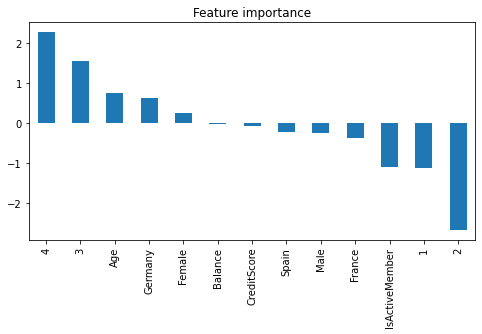

In [101]:
f, ax = plt.subplots(figsize= [8,4])

weights = pd.Series(LR.coef_[0], index=df.columns.values)
weights.sort_values(ascending = False).plot(kind='bar')

ax.set_title("Feature importance")
f.show()

Conclusions:

We can see that some variables have a negative relation to the churn, while some have positive relation. Negative relation means that likeliness of churn decreases with that variable.

The number of products 4 or 3, increasing Age, location in Germany, Female sex may lead to higher churn rates.

## K-nearest neighbors

In [102]:
KNN = KNeighborsClassifier(n_neighbors = 5)
KNN.fit(X_train, y_train)
y_pred2 = KNN.predict(X_test)

In [103]:
accuracy_score(y_test, y_pred2)

0.8476

In [104]:
param_grid2 = {'n_neighbors' : [3,4,5,6,7,8]}
search_KNN = GridSearchCV(KNN, param_grid2, cv=5)
search_KNN.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 4, 5, 6, 7, 8]})

In [105]:
search_KNN.best_params_

{'n_neighbors': 7}

In [106]:
KNN = KNeighborsClassifier(n_neighbors = 8)
KNN.fit(X_train, y_train)
y_pred2 = KNN.predict(X_test)

In [107]:
accuracy_score(y_test, y_pred2)

0.8548

In [108]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.87      0.97      0.91      2007
           1       0.75      0.40      0.52       493

    accuracy                           0.85      2500
   macro avg       0.81      0.68      0.72      2500
weighted avg       0.84      0.85      0.84      2500



## Support Vector Machine

In [109]:
SVM = SVC(kernel='poly')
SVM.fit(X_train, y_train)

SVC(kernel='poly')

In [110]:
y_pred3 = SVM.predict(X_test)

In [111]:
accuracy_score(y_test, y_pred3)

0.8552

In [112]:
param_grid3 = {'degree' : [2,3,4,5,6], 'kernel' : ['poly']}
search_SVM = GridSearchCV(SVM, param_grid3, cv=5)
search_SVM.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(kernel='poly'),
             param_grid={'degree': [2, 3, 4, 5, 6], 'kernel': ['poly']})

In [113]:
search_SVM.best_params_

{'degree': 4, 'kernel': 'poly'}

In [114]:
SVM = SVC(kernel='poly', degree=4)
SVM.fit(X_train, y_train)
y_pred3 = search_SVM.predict(X_test)

In [115]:
accuracy_score(y_test, y_pred3)

0.8596

In [116]:
print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      2007
           1       0.76      0.42      0.54       493

    accuracy                           0.86      2500
   macro avg       0.82      0.69      0.73      2500
weighted avg       0.85      0.86      0.84      2500



## Random Forest

In [117]:
RF = RandomForestClassifier()
RF.fit(X_train, y_train)

RandomForestClassifier()

In [118]:
y_pred4 = RF.predict(X_test)

In [119]:
accuracy_score(y_test, y_pred4)

0.8528

In [120]:
param_grid4 = {'min_samples_split' : [1,2,3], 'min_samples_leaf': [1,2,3], 'n_estimators': [100, 200]}
search_RF = GridSearchCV(RF, param_grid4, cv=5)
search_RF.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [1, 2, 3],
                         'n_estimators': [100, 200]})

In [121]:
search_RF.best_params_

{'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 100}

In [122]:
RF = RandomForestClassifier(min_samples_leaf=3, min_samples_split=3, n_estimators=200)
RF.fit(X_train, y_train)
y_pred4 = search_RF.predict(X_test)

In [123]:
accuracy_score(y_test, y_pred4)

0.8644

In [124]:
print(classification_report(y_test, y_pred4))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2007
           1       0.73      0.49      0.59       493

    accuracy                           0.86      2500
   macro avg       0.81      0.72      0.75      2500
weighted avg       0.85      0.86      0.85      2500



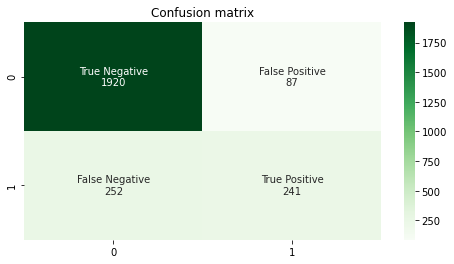

In [125]:
cm = confusion_matrix(y_test, y_pred4)

f, ax = plt.subplots(figsize= [8,4])

names = ['True Negative','False Positive','False Negative','True Positive']
counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Greens')

ax.set_title("Confusion matrix")
f.show()

In [126]:
w = RF.feature_importances_
print(w)


[0.16286747 0.31395565 0.17115902 0.05901559 0.00989216 0.01023989
 0.01269143 0.03175186 0.00910124 0.04669218 0.09037176 0.06706056
 0.0152012 ]


In [127]:
df.columns.values

array(['CreditScore', 'Age', 'Balance', 'IsActiveMember', 'Female',
       'Male', 'France', 'Germany', 'Spain', 1, 2, 3, 4], dtype=object)

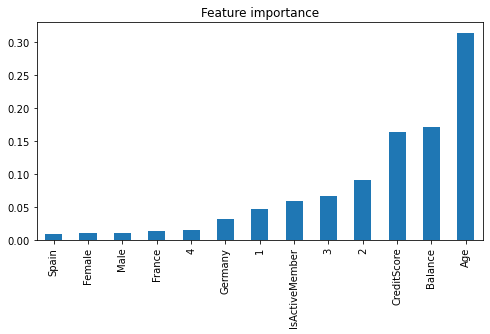

In [128]:
f, ax = plt.subplots(figsize= [8,4])

weights = pd.Series(w, index=df.columns.values)
weights.sort_values().plot(kind = 'bar')

ax.set_title("Feature importance")
f.show()

Conclusions:

We can see that "Age", "Balance" and "Credit Score" contribute the most.

# Model selection. Conclusions.